In [1]:
import os, gc, torch, PIL, pickle,json,io

import pandas as pd
from typing import List
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from utils.plot import plot_losses
from PIL import Image
from models.load import get_model_label, get_model_name, get_current_epoch, get_dataset_label, get_trained_model

from data.constants import DEFAULT_REFLACX_LABEL_COLS

import utils.print as print_f
from utils.init import reproducibility, clean_memory_get_device

# from models.load import TrainedModels
## Suppress the assignement warning from pandas.
pd.options.mode.chained_assignment = None  # default='warn

## Supress user warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

%matplotlib inline

In [2]:
device = clean_memory_get_device()
reproducibility()

This notebook will running on device: [CUDA]


In [3]:
from enum import Enum

class ImageSizeTest(Enum):
    size128 = "lesion-detection_val_ap_0_0856_test_ap_0_0693_epoch67_05-23-2023 13-53-13_baseline_mobilenet"
    size512 = "lesion-detection_val_ap_0_1283_test_ap_0_1174_epoch42_05-23-2023 16-38-06_baseline_mobilenet"

class APNatureModels(Enum):
    baseline_mobilenet = "lesion-detection_val_ap_0_1281_test_ap_0_1180_epoch49_05-17-2023 18-16-58_baseline_mobilenet"
    clinical_mobilenet_sum = "lesion-detection_val_ap_0_1542_test_ap_0_1294_epoch60_05-17-2023 21-23-17_clinical_mobilenet_sum"
    clinical_mobilenet_hadamard = "lesion-detection_val_ap_0_1296_test_ap_0_1427_epoch35_05-17-2023 23-33-46_clinical_mobilenet_hadamard"
    clinical_mobilenet_concat_conv = "lesion-detection_val_ap_0_1272_test_ap_0_1639_epoch35_05-18-2023 01-43-56_clinical_mobilenet_concat_conv"
    clinical_mobilenet_concat_linear = "lesion-detection_val_ap_0_1294_test_ap_0_1415_epoch55_05-18-2023 04-57-29_clinical_mobilenet_concat_linear"
    clinical_mobilenet_concat_convb = "lesion-detection_val_ap_0_1252_test_ap_0_1343_epoch61_05-18-2023 09-09-04_clinical_mobilenet_concat_convb"
    clinical_mobilenet_concat_conv_nb = "lesion-detection_val_ap_0_1220_test_ap_0_1149_epoch42_05-18-2023 22-56-01_clinical_mobilenet_concat_convb_nb"
    clinical_mobilenet_concat_conv_inter = "lesion-detection_val_ap_0_1233_test_ap_0_1402_epoch42_05-19-2023 01-13-45_clinical_mobilenet_concat_conv_inter"
    clinical_mobilenet_concat_conv_repeat = "lesion-detection_val_ap_0_1348_test_ap_0_1446_epoch60_05-19-2023 04-13-39_clinical_mobilenet_concat_conv_repeat"
    clinical_mobilenet_concat_deform = "lesion-detection_val_ap_0_1405_test_ap_0_1231_epoch47_05-19-2023 07-34-33_clinical_mobilenet_concat_deform"

class FROCNatureModels(Enum):

    baseline_mobilenet = "lesion-detection_val_froc_0_8257_test_froc_0_7691_epoch35_05-17-2023 17-46-23_baseline_mobilenet"
    clinical_mobilenet_sum = "lesion-detection_val_froc_0_8014_test_froc_0_7331_epoch31_05-17-2023 20-03-34_clinical_mobilenet_sum"
    clinical_mobilenet_hadamard = "lesion-detection_val_froc_0_8369_test_froc_0_7545_epoch25_05-17-2023 23-06-47_clinical_mobilenet_hadamard"
    clinical_mobilenet_concat_conv = "lesion-detection_val_froc_0_8185_test_froc_0_8069_epoch29_05-18-2023 01-26-37_clinical_mobilenet_concat_conv"
    clinical_mobilenet_concat_linear = "lesion-detection_val_froc_0_8233_test_froc_0_7907_epoch32_05-18-2023 03-48-49_clinical_mobilenet_concat_linear"
    clinical_mobilenet_concat_convb = "lesion-detection_val_froc_0_8047_test_froc_0_7226_epoch32_05-18-2023 07-51-15_clinical_mobilenet_concat_convb"
    clinical_mobilenet_concat_convb_nb = "lesion-detection_val_froc_0_8020_test_froc_0_7185_epoch30_05-18-2023 22-28-31_clinical_mobilenet_concat_convb_nb"
    clinical_mobilenet_concat_conv_inter = "lesion-detection_val_froc_0_8402_test_froc_0_7701_epoch26_05-19-2023 00-31-44_clinical_mobilenet_concat_conv_inter"
    clinical_mobilenet_concat_conv_repeat = "lesion-detection_val_froc_0_8312_test_froc_0_7636_epoch27_05-19-2023 02-54-07_clinical_mobilenet_concat_conv_repeat"
    clinical_mobilenet_concat_deform = "lesion-detection_val_froc_0_7905_test_froc_0_7824_epoch25_05-19-2023 06-14-09_clinical_mobilenet_concat_deform"

class NatureModels(Enum):
    clinical_convnext_base_sum_ap_3D = "lesion-detection_val_ap_0_1375_test_ap_0_1823_epoch22_05-16-2023 18-23-36_clinical_convnext_base_sum"
    clinical_convnext_base_sum_froc_3D = "lesion-detection_val_froc_0_8378_test_froc_0_7804_epoch26_05-16-2023 18-36-07_clinical_convnext_base_sum"
    clinical_convnext_base_sum_ar_3D = "lesion-detection_val_ar_0_6835_test_ar_0_6754_epoch39_05-16-2023 19-17-06_clinical_convnext_base_sum"
    baseline_convnext_base_ap = 'lesion-detection_val_ap_0_1560_test_ap_0_1567_epoch52_05-16-2023 22-20-39_baseline_convnext_base'
    baseline_convnext_base_froc = 'lesion-detection_val_froc_0_8560_test_froc_0_8079_epoch59_05-16-2023 22-47-45_baseline_convnext_base'
    baseline_convnext_base_ar = 'lesion-detection_val_ar_0_7054_test_ar_0_7032_epoch60_05-16-2023 22-51-45_baseline_convnext_base'
    clinical_convnext_base_sum_ap_1D_3D = "lesion-detection_val_ap_0_1373_test_ap_0_1393_epoch34_05-17-2023 02-45-30_clinical_convnext_base_sum"
    clinical_convnext_base_sum_froc_1D_3D = "lesion-detection_val_froc_0_8189_test_froc_0_7287_epoch157_05-17-2023 12-15-01_clinical_convnext_base_sum"
    clinical_convnext_base_sum_ar_1D_3D = "lesion-detection_val_ar_0_7309_test_ar_0_6901_epoch60_05-17-2023 07-00-34_clinical_convnext_base_sum"

class FROCEarlyStopModels(Enum):
    baseline_mobilenet = "val_lesion-detection_froc_0_8214_test_lesion-detection_froc_0_7215_epoch29_05-08-2023 03-29-15_lesion_dsetection_baseline_mobilenet"
    with_clinical_mobilenet_1D_3D = "val_lesion-detection_froc_0_7802_test_lesion-detection_froc_0_7193_epoch27_05-08-2023 04-57-59_lesion_dsetection_with_clinical_mobilenet"
    with_clinical_mobilenet_3D = "val_lesion-detection_froc_0_8345_test_lesion-detection_froc_0_7381_epoch31_05-08-2023 08-28-01_lesion_dsetection_with_clinical_mobilenet"
    baseline_resnet18 = "val_lesion-detection_froc_0_8262_test_lesion-detection_froc_0_7828_epoch21_05-08-2023 10-52-48_lesion_dsetection_baseline_resnet18"
    with_clinical_resnet18_1D_3D = "val_lesion-detection_froc_0_8063_test_lesion-detection_froc_0_7156_epoch21_05-08-2023 17-24-35_lesion_dsetection_with_clinical_resnet18"
    with_clinical_resnet18_3D = "val_lesion-detection_froc_0_8391_test_lesion-detection_froc_0_7007_epoch51_05-09-2023 00-03-18_lesion_dsetection_with_clinical_resnet18"
    baseline_convnext_base = "val_lesion-detection_froc_0_8422_test_lesion-detection_froc_0_7991_epoch39_05-09-2023 03-20-36_lesion_dsetection_baseline_convnext_base"
    with_clinical_convnext_base_1D_3D = "val_lesion-detection_froc_0_8248_test_lesion-detection_froc_0_7867_epoch45_05-09-2023 07-31-28_lesion_dsetection_with_clinical_convnext_base_1D_3D"
    with_clinical_convnext_base_3D = "val_lesion-detection_froc_0_8104_test_lesion-detection_froc_0_7584_epoch62_05-09-2023 12-56-34_lesion_dsetection_with_clinical_convnext_base_3D"
    with_clinical_convnext_base_3D_2nd = "val_lesion-detection_froc_0_8148_test_lesion-detection_froc_0_7649_epoch39_05-09-2023 17-27-41_lesion_dsetection_with_clinical_convnext_base_3D"
    with_clinical_convnext_base_1D_3D_2nd = "val_lesion-detection_froc_0_8409_test_lesion-detection_froc_0_8003_epoch29_05-09-2023 19-09-54_lesion_dsetection_with_clinical_convnext_base_1D_3D"
    baseline_convnext_base_2nd = "val_lesion-detection_froc_0_8597_test_lesion-detection_froc_0_8035_epoch41_05-09-2023 21-40-22_lesion_dsetection_baseline_convnext_base"
    baseline_efficientnet_b0 = "val_lesion-detection_froc_0_8301_test_lesion-detection_froc_0_7479_epoch23_05-09-2023 23-23-11_lesion_dsetection_baseline_efficientnet_b0"
    with_clinical_efficientnet_b0_1D_3D = "val_lesion-detection_froc_0_7876_test_lesion-detection_froc_0_7051_epoch35_05-10-2023 07-17-37_lesion_dsetection_with_clinical_efficientnet_b0_1D_3D"
    with_clinical_efficientnet_b0_3D = "val_lesion-detection_froc_0_8321_test_lesion-detection_froc_0_7246_epoch25_05-10-2023 09-19-11_lesion_dsetection_with_clinical_efficientnet_b0_3D"
    baseline_densenet = "val_lesion-detection_froc_0_8442_test_lesion-detection_froc_0_6942_epoch33_05-10-2023 17-06-03_lesion_dsetection_baseline_densenet"
    with_clinical_densenet_1D_3D = "val_lesion-detection_froc_0_8303_test_lesion-detection_froc_0_7089_epoch33_05-10-2023 19-11-45_lesion_dsetection_with_clinical_densenet_1D_3D"
    with_clinical_densenet_3D  = "val_lesion-detection_froc_0_8310_test_lesion-detection_froc_0_7144_epoch12_05-10-2023 20-13-22_lesion_dsetection_with_clinical_densenet_3D"
    baseline_resnet50 = "val_lesion-detection_froc_0_8350_test_lesion-detection_froc_0_7959_epoch15_05-10-2023 21-30-40_lesion_dsetection_baseline_resnet50"
    with_clinical_resnet50_1D_3D = "val_lesion-detection_froc_0_8119_test_lesion-detection_froc_0_7458_epoch15_05-10-2023 22-32-10_lesion_dsetection_with_clinical_resnet50_1D_3D"
    with_clinical_resnet50_3D = "val_lesion-detection_froc_0_8260_test_lesion-detection_froc_0_7630_epoch15_05-10-2023 23-35-14_lesion_dsetection_with_clinical_resnet50_3D"
    baseline_efficientnet_b5 = "val_lesion-detection_froc_0_8016_test_lesion-detection_froc_0_7337_epoch35_05-11-2023 01-44-17_lesion_dsetection_baseline_efficientnet_b5"
    with_clinical_efficientnet_b5_1D_3D = "val_lesion-detection_froc_0_8027_test_lesion-detection_froc_0_6531_epoch26_05-11-2023 03-42-43_lesion_dsetection_with_clinical_efficientnet_b5_1D_3D"
    with_clinical_efficientnet_b5_3D = "val_lesion-detection_froc_0_8209_test_lesion-detection_froc_0_6131_epoch34_05-11-2023 06-05-03_lesion_dsetection_with_clinical_efficientnet_b5_3D"
    with_clinical_convnext_base_3D_hadamard = "val_lesion-detection_froc_0_8236_test_lesion-detection_froc_0_7954_epoch42_05-11-2023 14-58-09_lesion_dsetection_with_clinical_convnext_base_3D_hadamard"

    # changed file names.
    with_clinical_convnext_base_3D_cocat_token_mixer = "val_froc_0_7650_test_froc_0_7231_epoch25_05-11-2023 19-32-51_clinical_convnext_3D_cocat_token_mixer"
    with_clinical_convnext_base_3D_hadamard_2nd = "val_froc_0_8186_test_froc_0_7648_epoch61_05-11-2023 22-43-35_clinical_convnext_3D_hadamard"
    with_clinical_expander_convnext_base_3D_cocat = "val_froc_0_8453_test_froc_0_7186_epoch51_05-12-2023 02-57-57_clinical_expander_convnext_3D_cocat"
    with_clinical_convnext_base_3D_cocat = "val_froc_0_7863_test_froc_0_7991_epoch13_05-12-2023 04-03-12_clinical_convnext_3D_cocat"
    with_clinical_convnext_base_3D_cocat_with_norm_act_token_mixer = "val_froc_0_7976_test_froc_0_7680_epoch28_05-12-2023 15-26-58_clinical_convnext_3D_cocat_with_mixer"
    with_clinical_convnext_base_3D_cocat_pos_weight_10 = "val_froc_0_8070_test_froc_0_7986_epoch18_05-12-2023 21-53-37_clinical_convnext_3D_cocat_pos_weight_10"
    with_clinical_convnext_base_3D_cocat_pos_weight_100 = "val_froc_0_7888_test_froc_0_7747_epoch13_05-12-2023 23-17-06_clinical_convnext_3D_cocat_pos_weight_100"
    with_clinical_convnext_base_3D_cocat_pos_weight_10_2nd = "val_froc_0_8227_test_froc_0_7324_epoch70_05-13-2023 04-26-25_clinical_convnext_3D_cocat_pos_weight_10"
    with_clinical_convnext_base_3D_cocat_pos_weight_100_2nd  = "val_froc_0_8216_test_froc_0_7314_epoch65_05-13-2023 07-51-16_clinical_convnext_3D_cocat_pos_weight_100"

    ap_lesion_dsetection_with_clinical_convnext_base_3D = "val_lesion-detection_ap_0_1290_test_lesion-detection_ap_0_1564_epoch60_05-14-2023 00-32-39_lesion_dsetection_with_clinical_convnext_base_3D"
    ap_lesion_dsetection_with_clinical_convnext_base_1D_3D = "val_lesion-detection_ap_0_0970_test_lesion-detection_ap_0_1072_epoch56_05-14-2023 03-54-58_lesion_dsetection_with_clinical_convnext_base_1D_3D"
    ap_lesion_dsetection_baseline_convnext_base = "val_lesion-detection_ap_0_1309_test_lesion-detection_ap_0_1245_epoch56_05-14-2023 07-09-35_lesion_dsetection_baseline_convnext_base"
    ap_clinical_efficientnet_b0_3D =  "val_lesion-detection_ap_0_1138_test_lesion-detection_ap_0_1088_epoch68_05-14-2023 17-09-14_clinical_efficientnet_b0_3D"
    ap_clinical_efficientnet_b0_1D_3D =  "val_lesion-detection_ap_0_1202_test_lesion-detection_ap_0_1081_epoch30_05-14-2023 19-10-56_clinical_efficientnet_b0_1D_3D"
    ap_baseline_efficientnet_b0 =  "val_lesion-detection_ap_0_1127_test_lesion-detection_ap_0_1156_epoch36_05-14-2023 21-39-07_baseline_efficientnet_b0"
    
    ap_clinical_densenet_3D = "val_lesion-detection_ap_0_1240_test_lesion-detection_ap_0_1129_epoch56_05-15-2023 13-04-42_clinical_densenet_3D"
    ap_clinical_densenet_1D_3D = "val_lesion-detection_ap_0_1182_test_lesion-detection_ap_0_1200_epoch26_05-15-2023 16-25-55_clinical_densenet_1D_3D"
    ap_baseline_densenet = "val_lesion-detection_ap_0_1382_test_lesion-detection_ap_0_1230_epoch21_05-15-2023 18-19-01_baseline_densenet"

    # file names too long.
    # with_clinical_convnext_base_3D_cocat_token_mixer = "val_lesion-detection_froc_0_7650_test_lesion-detection_froc_0_7231_epoch25_05-11-2023 19-32-51_lesion_dsetection_with_clinical_convnext_base_3D_cocat_token_mixer"
    # with_clinical_convnext_base_3D_hadamard_2nd = "val_lesion-detection_froc_0_8186_test_lesion-detection_froc_0_7648_epoch61_05-11-2023 22-43-35_lesion_dsetection_with_clinical_convnext_base_3D_hadamard"
    # with_clinical_expander_convnext_base_3D_cocat = "val_lesion-detection_froc_0_8453_test_lesion-detection_froc_0_7186_epoch51_05-12-2023 02-57-57_lesion_dsetection_with_clinical_expander_convnext_base_3D_cocat"
    # with_clinical_convnext_base_3D_cocat = "val_lesion-detection_froc_0_7863_test_lesion-detection_froc_0_7991_epoch13_05-12-2023 04-03-12_lesion_dsetection_with_clinical_convnext_base_3D_cocat"
    # with_clinical_convnext_base_3D_cocat_with_norm_act_token_mixer = "val_lesion-detection_froc_0_7976_test_lesion-detection_froc_0_7680_epoch28_05-12-2023 15-26-58_lesion_dsetection_with_clinical_convnext_base_3D_cocat_with_norm_act_token_mixer"
    # with_clinical_convnext_base_3D_cocat_pos_weight_10 = "val_lesion-detection_froc_0_8070_test_lesion-detection_froc_0_7986_epoch18_05-12-2023 21-53-37_lesion_dsetection_with_clinical_convnext_base_3D_cocat_pos_weight_10"
    # with_clinical_convnext_base_3D_cocat_pos_weight_100 = "val_lesion-detection_froc_0_7888_test_lesion-detection_froc_0_7747_epoch13_05-12-2023 23-17-06_lesion_dsetection_with_clinical_convnext_base_3D_cocat_pos_weight_100"
    # with_clinical_convnext_base_3D_cocat_pos_weight_10_2nd = "val_lesion-detection_froc_0_8227_test_lesion-detection_froc_0_7324_epoch70_05-13-2023 04-26-25_lesion_dsetection_with_clinical_convnext_base_3D_cocat_pos_weight_10"
    # with_clinical_convnext_base_3D_cocat_pos_weight_100_2nd  = "val_lesion-detection_froc_0_8216_test_lesion-detection_froc_0_7314_epoch65_05-13-2023 07-51-16_lesion_dsetection_with_clinical_convnext_base_3D_cocat_pos_weight_100"

class RetrainedModels(Enum):
    mobilenet_with_fix = "val_lesion-detection_froc_0_7916_test_lesion-detection_froc_0_8150_epoch15_04-01-2023 03-02-43_lesion_dsetection_with_fix_mobilenet"
    mobilenet_baseline = "val_lesion-detection_froc_0_7764_test_lesion-detection_froc_0_8036_epoch8_04-01-2023 07-46-01_lesion_dsetection_baseline_mobilenet"
    resnet18_with_fix = "val_lesion-detection_froc_0_7982_test_lesion-detection_froc_0_8257_epoch5_04-01-2023 11-24-08_lesion_dsetection_with_fix_resnet18"
    resnet18_baseline = "val_lesion-detection_froc_0_7893_test_lesion-detection_froc_0_8075_epoch5_04-01-2023 13-53-42_lesion_dsetection_baseline_resnet18"
    densenet_with_fix = "val_lesion-detection_froc_0_8004_test_lesion-detection_froc_0_8169_epoch12_04-02-2023 03-08-03_lesion_dsetection_with_fix_densenet"
    densenet_baseline = "val_lesion-detection_froc_0_7841_test_lesion-detection_froc_0_7864_epoch7_04-02-2023 06-38-49_lesion_dsetection_baseline_densenet"
    efficientnet_b5_with_fix = "val_lesion-detection_froc_0_7980_test_lesion-detection_froc_0_8006_epoch7_04-02-2023 19-25-56_lesion_dsetection_with_fix_efficientnet_b5"
    efficientnet_b5_baseline = "val_lesion-detection_froc_0_7846_test_lesion-detection_froc_0_8189_epoch5_04-02-2023 22-14-38_lesion_dsetection_baseline_efficientnet_b5"
    efficientnet_b0_with_fix = "val_lesion-detection_froc_0_8030_test_lesion-detection_froc_0_8089_epoch7_04-02-2023 12-42-11_lesion_dsetection_with_fix_efficientnet_b0"
    efficientnet_b0_baseline = "val_lesion-detection_froc_0_7939_test_lesion-detection_froc_0_8115_epoch5_04-02-2023 15-17-34_lesion_dsetection_baseline_efficientnet_b0"
    vgg16_with_fix = "val_lesion-detection_froc_0_8004_test_lesion-detection_froc_0_8247_epoch9_04-03-2023 01-53-49_lesion_dsetection_with_fix_vgg16"
    vgg16_baseline = "val_lesion-detection_froc_0_7903_test_lesion-detection_froc_0_7991_epoch8_04-03-2023 04-59-07_lesion_dsetection_baseline_vgg16"
    regnet_y_8gf_with_fix ="val_lesion-detection_froc_0_8059_test_lesion-detection_froc_0_8284_epoch7_04-03-2023 10-01-30_lesion_dsetection_with_fix_regnet_y_8gf"
    regnet_y_8gf_baseline = "val_lesion-detection_froc_0_7862_test_lesion-detection_froc_0_8172_epoch5_04-03-2023 14-04-49_lesion_dsetection_baseline_regnet_y_8gf"
    convnext_base_with_fix = "val_lesion-detection_froc_0_8141_test_lesion-detection_froc_0_8278_epoch7_04-03-2023 17-07-24_lesion_dsetection_with_fix_convnext_base"
    convnext_base_baseline = "val_lesion-detection_froc_0_7903_test_lesion-detection_froc_0_8092_epoch11_04-03-2023 21-17-10_lesion_dsetection_baseline_convnext_base"
    resnet50_with_fix = "val_lesion-detection_froc_0_8201_test_lesion-detection_froc_0_8307_epoch7_04-04-2023 01-13-30_lesion_dsetection_with_fix_resnet50"
    resnet50_baseline = "val_lesion-detection_froc_0_7882_test_lesion-detection_froc_0_8111_epoch6_04-04-2023 04-00-17_lesion_dsetection_baseline_resnet50"
    resnet50_with_fix_silent = "val_lesion-detection_froc_0_7947_test_lesion-detection_froc_0_8172_epoch8_04-04-2023 22-46-16_ld_with_fix_resnet50_silent"
    resnet50_with_fix_full = "val_lesion-detection_froc_0_8135_test_lesion-detection_froc_0_8361_epoch10_04-05-2023 04-40-29_ld_with_fix_resnet50_full"
    
class TrainedModels(Enum):
    mobilenet_baseline = "val_lesion-detection_ap_0_1655_test_lesion-detection_ap_0_1648_epoch50_03-15-2023 16-43-54_lesion_dsetection_baseline_mobilenet"  # mobilenet baseline
    mobilenet_with_fix = "val_lesion-detection_ap_0_1918_test_lesion-detection_ap_0_1903_epoch16_03-16-2023 11-34-10_lesion_dsetection_with_fixation_mobilenet"
    resnet18_baseline = "val_lesion-detection_ap_0_1973_test_lesion-detection_ap_0_2010_epoch22_03-16-2023 19-44-55_lesion_dsetection_baseline_resnet"
    resnet18_with_fix = "val_lesion-detection_ap_0_1951_test_lesion-detection_ap_0_2195_epoch12_03-17-2023 00-31-54_lesion_dsetection_with_fixation_resnet"
    densenet161_baseline = "val_lesion-detection_ap_0_1990_test_lesion-detection_ap_0_2085_epoch5_03-17-2023 08-53-33_lesion_dsetection_baseline_densenet161"
    densenet161_with_fix = "val_lesion-detection_ap_0_2120_test_lesion-detection_ap_0_2104_epoch12_03-17-2023 18-36-01_lesion_dsetection_with_fixation_densenet161"
    efficientnet_b5_baseline = "val_lesion-detection_ap_0_1898_test_lesion-detection_ap_0_2055_epoch5_03-17-2023 23-30-57_lesion_dsetection_baseline_efficientnet_b5"
    efficientnet_b5_with_fix = "val_lesion-detection_ap_0_2117_test_lesion-detection_ap_0_2190_epoch8_03-18-2023 12-29-20_lesion_dsetection_with_fixation_efficientnet_b5"
    efficientnet_b0_baseline = "val_lesion-detection_ap_0_1934_test_lesion-detection_ap_0_1858_epoch10_03-18-2023 23-50-47_lesion_dsetection_baseline_efficientnet_b0"
    efficientnet_b0_with_fix = "val_lesion-detection_ap_0_2191_test_lesion-detection_ap_0_2162_epoch10_03-18-2023 19-38-11_lesion_dsetection_with_fixation_efficientnet_b0"
    convnext_base_with_fix = "val_lesion-detection_ap_0_2472_test_lesion-detection_ap_0_2637_epoch15_03-23-2023 20-20-07_lesion_dsetection_with_fixation_convnext_base_silent_report"
    # convnext_base_with_fix = "val_lesion-detection_ap_0_2610_test_lesion-detection_ap_0_2548_epoch22_03-22-2023 02-55-37_lesion_dsetection_with_fixation_convnext_base"
    convnext_base_baseline = "val_lesion-detection_ap_0_2426_test_lesion-detection_ap_0_2325_epoch20_03-22-2023 11-53-53_lesion_dsetection_baseline_convnext_base"
    convnext_base_with_fix_silent = "val_lesion-detection_ap_0_2405_test_lesion-detection_ap_0_2543_epoch19_03-24-2023 13-57-29_lesion_dsetection_with_fixation_convnext_base_silent_report"
    convnext_base_with_fix_full = "val_lesion-detection_ap_0_2602_test_lesion-detection_ap_0_2499_epoch22_03-24-2023 04-42-21_lesion_dsetection_with_fixation_convnext_base_full_report"
    vgg16_with_fix = "val_lesion-detection_ap_0_2301_test_lesion-detection_ap_0_2186_epoch22_03-20-2023 19-26-02_lesion_dsetection_with_fixation_vgg16"
    vgg16_baseline = "val_lesion-detection_ap_0_2113_test_lesion-detection_ap_0_2068_epoch12_03-21-2023 00-45-24_lesion_dsetection_baseline_vgg16"
    regnet_y_8gf_with_fix = "val_lesion-detection_ap_0_2267_test_lesion-detection_ap_0_2029_epoch12_03-21-2023 11-28-48_lesion_dsetection_with_fixation_regnet_y_8gf"
    regnet_y_8gf_baseline = "val_lesion-detection_ap_0_1883_test_lesion-detection_ap_0_1658_epoch13_03-21-2023 15-22-32_lesion_dsetection_baseline_regnet_y_8gf"

In [4]:
naming_map = {
    ImageSizeTest.size512: "size512",
    ImageSizeTest.size128: "size128",
    APNatureModels.baseline_mobilenet: "baseline_mobilenet",
    APNatureModels.clinical_mobilenet_sum: "clinical_mobilenet_sum",
    APNatureModels.clinical_mobilenet_hadamard: "clinical_mobilenet_hadamard",
    APNatureModels.clinical_mobilenet_concat_conv: "clinical_mobilenet_concat_conv",
    APNatureModels.clinical_mobilenet_concat_linear: "clinical_mobilenet_concat_linear",
    APNatureModels.clinical_mobilenet_concat_convb: "clinical_mobilenet_concat_convb",
    APNatureModels.clinical_mobilenet_concat_conv_nb: "clinical_mobilenet_concat_conv_nb",
    APNatureModels.clinical_mobilenet_concat_conv_inter: "clinical_mobilenet_concat_conv_inter",
    APNatureModels.clinical_mobilenet_concat_conv_repeat: "clinical_mobilenet_concat_conv_repeat",
    APNatureModels.clinical_mobilenet_concat_deform : "clinical_mobilenet_concat_deform",
    FROCNatureModels.baseline_mobilenet: "baseline_mobilenet",
    FROCNatureModels.clinical_mobilenet_sum: "clinical_mobilenet_sum",
    FROCNatureModels.clinical_mobilenet_hadamard: "clinical_mobilenet_hadamard",
    FROCNatureModels.clinical_mobilenet_concat_conv: "clinical_mobilenet_concat_conv",
    FROCNatureModels.clinical_mobilenet_concat_linear: "clinical_mobilenet_concat_linear",
    FROCNatureModels.clinical_mobilenet_concat_convb: "clinical_mobilenet_concat_convb",
    FROCNatureModels.clinical_mobilenet_concat_convb_nb: "clinical_mobilenet_concat_convb_nb",
    FROCNatureModels.clinical_mobilenet_concat_conv_inter: "clinical_mobilenet_concat_conv_inter",
    FROCNatureModels.clinical_mobilenet_concat_conv_repeat: "clinical_mobilenet_concat_conv_repeat",
    FROCNatureModels.clinical_mobilenet_concat_deform: "clinical_mobilenet_concat_deform",
    NatureModels.clinical_convnext_base_sum_ap_3D: "clinical_convnext_base_sum_ap_3D",
    NatureModels.clinical_convnext_base_sum_froc_3D: "clinical_convnext_base_sum_froc_3D",
    NatureModels.clinical_convnext_base_sum_ar_3D: "clinical_convnext_base_sum_ar_3D",
    NatureModels.baseline_convnext_base_ap: "baseline_convnext_base_ap",
    NatureModels.baseline_convnext_base_froc: "baseline_convnext_base_froc",
    NatureModels.baseline_convnext_base_ar: "baseline_convnext_base_ar",
    NatureModels.clinical_convnext_base_sum_ap_1D_3D: "clinical_convnext_base_sum_ap_1D_3D",
    NatureModels.clinical_convnext_base_sum_froc_1D_3D: "clinical_convnext_base_sum_froc_1D_3D",
    NatureModels.clinical_convnext_base_sum_ar_1D_3D: "clinical_convnext_base_sum_ar_1D_3D",
    FROCEarlyStopModels.baseline_mobilenet: "baseline_mobilenet",
    FROCEarlyStopModels.baseline_mobilenet: "baseline_mobilenet",
    FROCEarlyStopModels.with_clinical_mobilenet_1D_3D: "with_clinical_mobilenet_1D_3D",
    FROCEarlyStopModels.with_clinical_mobilenet_3D: "with_clinical_mobilenet_3D",
    FROCEarlyStopModels.baseline_resnet18: "baseline_resnet18",
    FROCEarlyStopModels.with_clinical_resnet18_1D_3D: "with_clinical_resnet18_1D_3D",
    FROCEarlyStopModels.with_clinical_resnet18_3D: "with_clinical_resnet18_3D",
    FROCEarlyStopModels.baseline_convnext_base: "baseline_convnext_base",
    FROCEarlyStopModels.with_clinical_convnext_base_1D_3D: "with_clinical_convnext_base_1D_3D",
    FROCEarlyStopModels.with_clinical_convnext_base_3D: "with_clinical_convnext_base_3D",
    FROCEarlyStopModels.with_clinical_convnext_base_3D_2nd: "with_clinical_convnext_base_3D_2nd",
    FROCEarlyStopModels.with_clinical_convnext_base_1D_3D_2nd: "with_clinical_convnext_base_1D_3D_2nd",
    FROCEarlyStopModels.baseline_convnext_base_2nd: "baseline_convnext_base_2nd",
    FROCEarlyStopModels.baseline_efficientnet_b0: "baseline_efficientnet_b0",
    FROCEarlyStopModels.with_clinical_efficientnet_b0_1D_3D: "with_clinical_efficientnet_b0_1D_3D",
    FROCEarlyStopModels.with_clinical_efficientnet_b0_3D: "with_clinical_efficientnet_b0_3D",
    FROCEarlyStopModels.baseline_densenet: "baseline_densenet",
    FROCEarlyStopModels.with_clinical_densenet_1D_3D: "with_clinical_densenet_1D_3D",
    FROCEarlyStopModels.with_clinical_densenet_3D: "with_clinical_densenet_3D",
    FROCEarlyStopModels.baseline_resnet50: "baseline_resnet50",
    FROCEarlyStopModels.with_clinical_resnet50_1D_3D: "with_clinical_resnet50_1D_3D",
    FROCEarlyStopModels.with_clinical_resnet50_3D: "with_clinical_resnet50_3D",
    FROCEarlyStopModels.baseline_efficientnet_b5: "baseline_efficientnet_b5",
    FROCEarlyStopModels.with_clinical_efficientnet_b5_1D_3D: "with_clinical_efficientnet_b5_1D_3D",
    FROCEarlyStopModels.with_clinical_efficientnet_b5_3D: "with_clinical_efficientnet_b5_3D",
    FROCEarlyStopModels.with_clinical_convnext_base_3D_hadamard: "with_clinical_convnext_base_3D_hadamard",
    FROCEarlyStopModels.with_clinical_convnext_base_3D_cocat_token_mixer: "with_clinical_convnext_base_3D_cocat_token_mixer",
    FROCEarlyStopModels.with_clinical_convnext_base_3D_hadamard_2nd: "with_clinical_convnext_base_3D_hadamard_2nd",
    FROCEarlyStopModels.with_clinical_expander_convnext_base_3D_cocat: "with_clinical_expander_convnext_base_3D_cocat",
    FROCEarlyStopModels.with_clinical_convnext_base_3D_cocat: "with_clinical_convnext_base_3D_cocat",
    FROCEarlyStopModels.with_clinical_convnext_base_3D_cocat_with_norm_act_token_mixer: "with_clinical_convnext_base_3D_cocat_with_norm_act_token_mixer",
    FROCEarlyStopModels.with_clinical_convnext_base_3D_cocat_pos_weight_10: "with_clinical_convnext_base_3D_cocat_pos_weight_10",
    FROCEarlyStopModels.with_clinical_convnext_base_3D_cocat_pos_weight_100: "with_clinical_convnext_base_3D_cocat_pos_weight_100",
    FROCEarlyStopModels.with_clinical_convnext_base_3D_cocat_pos_weight_10_2nd: "with_clinical_convnext_base_3D_cocat_pos_weight_10_2nd",
    FROCEarlyStopModels.with_clinical_convnext_base_3D_cocat_pos_weight_100_2nd: "with_clinical_convnext_base_3D_cocat_pos_weight_100_2nd",
    FROCEarlyStopModels.ap_lesion_dsetection_with_clinical_convnext_base_3D: "ap_lesion_dsetection_with_clinical_convnext_base_3D",
    FROCEarlyStopModels.ap_lesion_dsetection_with_clinical_convnext_base_1D_3D: "ap_lesion_dsetection_with_clinical_convnext_base_1D_3D",
    FROCEarlyStopModels.ap_lesion_dsetection_baseline_convnext_base: "ap_lesion_dsetection_baseline_convnext_base",
    FROCEarlyStopModels.ap_clinical_efficientnet_b0_3D: "ap_clinical_efficientnet_b0_3D",
    FROCEarlyStopModels.ap_clinical_efficientnet_b0_1D_3D: "ap_clinical_efficientnet_b0_1D_3D",
    FROCEarlyStopModels.ap_baseline_efficientnet_b0: "ap_baseline_efficientnet_b0",
    FROCEarlyStopModels.ap_clinical_densenet_3D: "ap_clinical_densenet_3D",
    FROCEarlyStopModels.ap_clinical_densenet_1D_3D: "ap_clinical_densenet_1D_3D",
    FROCEarlyStopModels.ap_baseline_densenet: "ap_baseline_densenet",
    TrainedModels.mobilenet_baseline: "mobilenet_baseline (ap)",
    TrainedModels.mobilenet_with_fix: "mobilenet_with_fix (ap)",
    TrainedModels.resnet18_baseline: "resnet18_baseline (ap)",
    TrainedModels.resnet18_with_fix: "resnet18_with_fix (ap)",
    TrainedModels.densenet161_baseline: "densenet161_baseline (ap)",
    TrainedModels.densenet161_with_fix: "densenet161_with_fix (ap)",
    TrainedModels.efficientnet_b5_baseline: "efficientnet_b5_baseline (ap)",
    TrainedModels.efficientnet_b5_with_fix: "efficientnet_b5_with_fix (ap)",
    TrainedModels.efficientnet_b0_baseline: "efficientnet_b0_baseline (ap)",
    TrainedModels.efficientnet_b0_with_fix: "efficientnet_b0_with_fix (ap)",
    TrainedModels.convnext_base_with_fix: "convnext_base_with_fix (ap)",
    TrainedModels.convnext_base_baseline: "convnext_base_baseline (ap)",
    TrainedModels.convnext_base_with_fix_silent: "convnext_base_with_fix_silent (ap)",
    TrainedModels.convnext_base_with_fix_full: "convnext_base_with_fix_full (ap)",
    TrainedModels.vgg16_with_fix: "vgg16_with_fix (ap)",
    TrainedModels.vgg16_baseline: "vgg16_baseline (ap)",
    TrainedModels.regnet_y_8gf_with_fix: "regnet_y_8gf_with_fix (ap)",
    TrainedModels.regnet_y_8gf_baseline: "regnet_y_8gf_baseline (ap)",
    RetrainedModels.mobilenet_with_fix: "mobilenet_with_fix (froc)",
    RetrainedModels.mobilenet_baseline: "mobilenet_baseline (froc)",
    RetrainedModels.resnet18_with_fix: "resnet18_with_fix (froc)",
    RetrainedModels.resnet18_baseline: "resnet18_baseline (froc)",
    RetrainedModels.densenet_with_fix: "densenet_with_fix (froc)",
    RetrainedModels.densenet_baseline: "densenet_baseline (froc)",
    RetrainedModels.efficientnet_b5_with_fix: "efficientnet_b5_with_fix (froc)",
    RetrainedModels.efficientnet_b5_baseline: "efficientnet_b5_baseline (froc)",
    RetrainedModels.efficientnet_b0_with_fix: "efficientnet_b0_with_fix (froc)",
    RetrainedModels.efficientnet_b0_baseline: "efficientnet_b0_baseline (froc)",
    RetrainedModels.vgg16_with_fix: "vgg16_with_fix (froc)",
    RetrainedModels.vgg16_baseline: "vgg16_baseline (froc)",
    RetrainedModels.regnet_y_8gf_with_fix: "regnet_y_8gf_with_fix (froc)",
    RetrainedModels.regnet_y_8gf_baseline: "regnet_y_8gf_baseline (froc)",
    RetrainedModels.convnext_base_with_fix: "convnext_base_with_fix (froc)",
    RetrainedModels.convnext_base_baseline: "convnext_base_baseline (froc)",
    RetrainedModels.resnet50_with_fix: "resnet50_with_fix (froc)",
    RetrainedModels.resnet50_baseline: "resnet50_baseline (froc)",
    RetrainedModels.resnet50_with_fix_silent: "resnet50_with_fix (silent) (froc)",
    RetrainedModels.resnet50_with_fix_full: "resnet50_with_fix (full) (froc)",
}


In [5]:
score_thrs="0.05"

In [6]:
from pathlib import Path

In [7]:
eval_ss = []

save_prefix = "image_size"
for select_model in ImageSizeTest:
    model_path = select_model.value
    for l in DEFAULT_REFLACX_LABEL_COLS + ["all"]:
        eval_df = pd.read_csv(
            Path(os.path.join(
                "./eval_results",
                f"{model_path}_{l}_{score_thrs}.csv",
            )),
            index_col=0,
        )
        eval_s = eval_df.iloc[0]
        eval_s["model"] = naming_map[select_model]
        eval_s["lesion"] = l
        eval_s["score_threshold"] = score_thrs
        states = json.loads(eval_s["coco_states"])
        for s in states:
            eval_s[s["p_title_str"]] = s["mean_s"]
        eval_ss.append(eval_s)


In [8]:
eval_df = pd.DataFrame(eval_ss)

In [9]:
eval_df

,num_fps,num_fns,num_tps,coco_states,Sensitivity@ [avgFP=0.5],Sensitivity@ [avgFP=1],Sensitivity@ [avgFP=2],Sensitivity@ [avgFP=4],"mFROC@[0.5,1,2,4]",froc_curve,...,Average Precision (AP) @[ IoBB=0.50:0.95 | area= large | maxDets= 10 ],Average Recall (AR) @[ IoBB=0.50:0.95 | area= all | maxDets= 1 ],Average Recall (AR) @[ IoBB=0.50:0.95 | area= all | maxDets= 5 ],Average Recall (AR) @[ IoBB=0.50:0.95 | area= all | maxDets= 10 ],Average Recall (AR) @[ IoBB=0.50:0.95 | area= all | maxDets= 30 ],Average Recall (AR) @[ IoBB=0.50 | area= all | maxDets= 10 ],Average Recall (AR) @[ IoBB=0.50 | area= all | maxDets= 30 ],Average Recall (AR) @[ IoBB=0.50:0.95 | area= small | maxDets= 10 ],Average Recall (AR) @[ IoBB=0.50:0.95 | area=medium | maxDets= 10 ],Average Recall (AR) @[ IoBB=0.50:0.95 | area= large | maxDets= 10 ]
0,122,33,9,"[{""ap"": 1, ""iouThr"": null, ""areaRng"": ""all"", ""...",0.333333,0.460317,0.600564,0.813530,0.551936,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,0.019650,0.071429,0.135714,0.145238,0.145238,0.214286,0.214286,-1,-1,0.145238
0,56,34,26,"[{""ap"": 1, ""iouThr"": null, ""areaRng"": ""all"", ""...",0.623810,0.746899,0.933333,0.943737,0.811945,"[0.015866666666666668, 0.016811688177871507, 0...",...,0.153749,0.230000,0.290000,0.301667,0.301667,0.433333,0.433333,-1,-1,0.301667
0,70,45,10,"[{""ap"": 1, ""iouThr"": null, ""areaRng"": ""all"", ""...",0.345455,0.483794,0.689177,0.821099,0.584881,"[0.0074181818181818186, 0.007860010057186678, ...",...,0.029241,0.036364,0.129091,0.132727,0.132727,0.181818,0.181818,-1,-1,0.132727
0,37,53,6,"[{""ap"": 1, ""iouThr"": null, ""areaRng"": ""all"", ""...",0.341404,0.492607,0.724087,0.820708,0.594702,"[0.0023050847457627118, 0.002442376006470437, ...",...,0.006205,0.023729,0.045763,0.045763,0.045763,0.101695,0.101695,-1,-1,0.045763
0,11,54,1,"[{""ap"": 1, ""iouThr"": null, ""areaRng"": ""all"", ""...",0.425455,0.549091,0.602942,0.651634,0.557281,"[0.0024727272727272727, 0.0026200033523955594,...",...,0.002228,0.016364,0.016364,0.016364,0.016364,0.018182,0.018182,-1,-1,0.016364
0,296,219,52,"[{""ap"": 1, ""iouThr"": null, ""areaRng"": ""all"", ""...",0.420559,0.553579,0.719599,0.812600,0.626584,"[0.006022140221402215, 0.0063808199726238714, ...",...,0.042214,0.075577,0.123386,0.128352,0.128352,0.189863,0.189863,-1,-1,0.128352
0,242,21,21,"[{""ap"": 1, ""iouThr"": null, ""areaRng"": ""all"", ""...",0.285714,0.619048,0.825397,0.940623,0.667695,"[0.0032380952380952383, 0.003430956770994185, ...",...,0.070763,0.211905,0.383333,0.426190,0.426190,0.500000,0.500000,-1,-1,0.426190
0,128,29,31,"[{""ap"": 1, ""iouThr"": null, ""areaRng"": ""all"", ""...",0.596667,0.701667,0.890183,0.990213,0.794682,"[0.011333333333333332, 0.012008348698479646, 0...",...,0.189007,0.335000,0.411667,0.415000,0.415000,0.516667,0.516667,-1,-1,0.415000
0,77,35,20,"[{""ap"": 1, ""iouThr"": null, ""areaRng"": ""all"", ""...",0.604545,0.698396,0.808192,0.929790,0.760231,"[0.0074181818181818186, 0.007860010057186678, ...",...,0.093639,0.105455,0.252727,0.265455,0.269091,0.363636,0.363636,-1,-1,0.265455
0,56,39,20,"[{""ap"": 1, ""iouThr"": null, ""areaRng"": ""all"", ""...",0.556714,0.684447,0.830688,0.872554,0.736101,"[0.0046101694915254236, 0.004884752012940874, ...",...,0.083868,0.116949,0.218644,0.218644,0.218644,0.338983,0.338983,-1,-1,0.218644


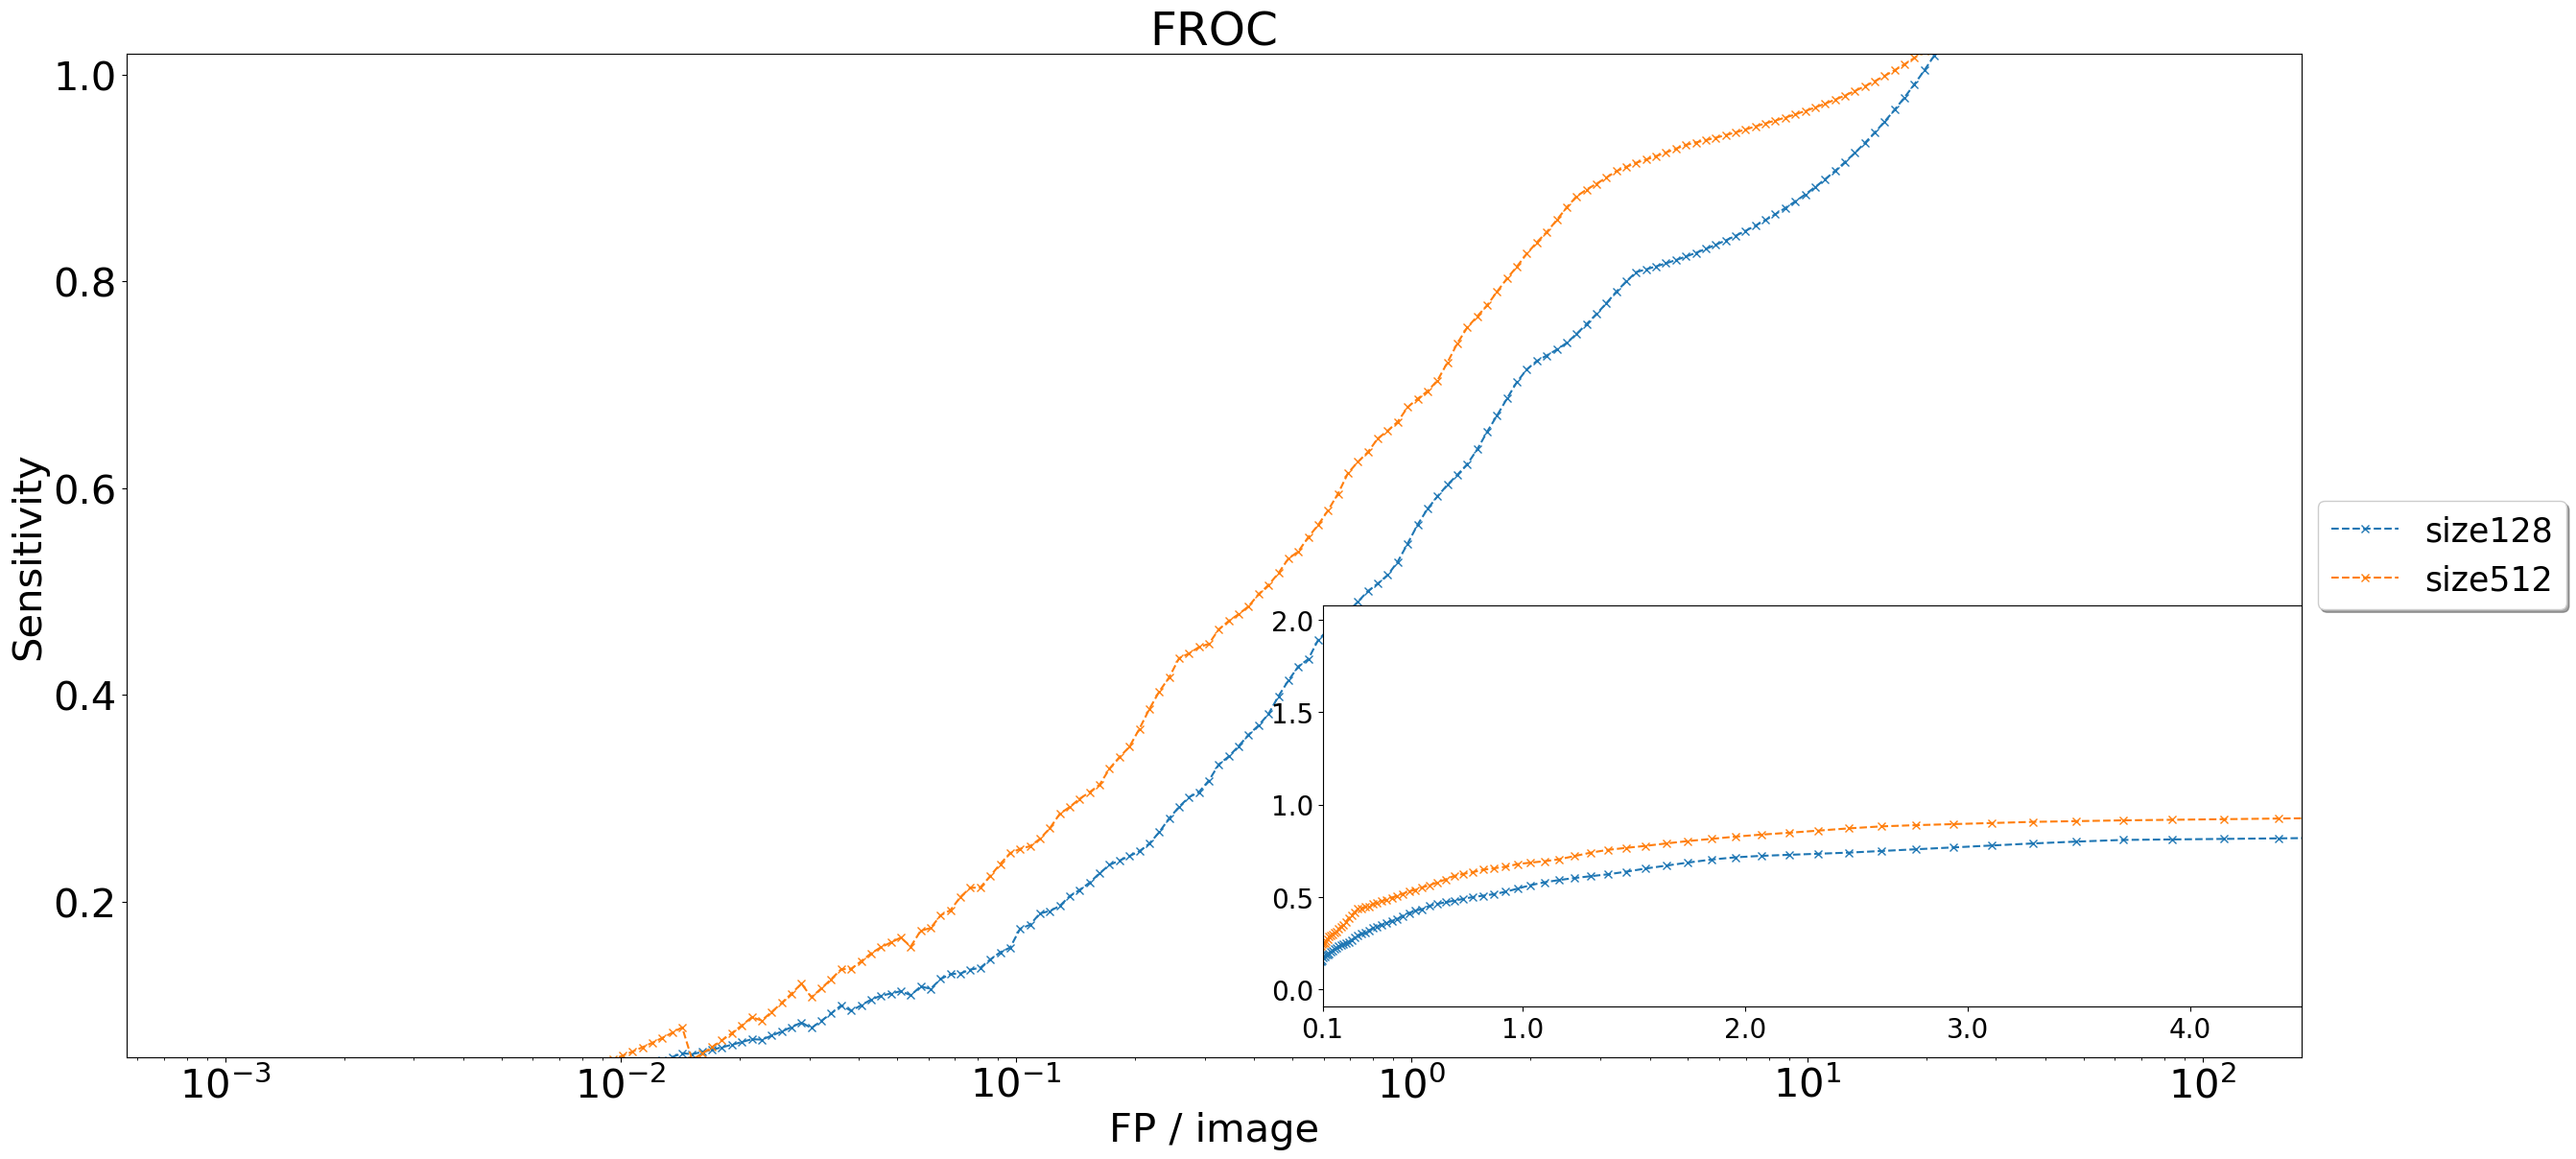

In [10]:
fig, ax = plt.subplots(figsize=[25, 13])

ins = ax.inset_axes([0.55, 0.05, 0.45, 0.4])
ins.set_xticks(
    [0.1, 1.0, 2.0, 3.0, 4.0],
    [
        0.1,
        1.0,
        2.0,
        3.0,
        4.0,
    ],
    fontsize=30,
)

ins.set_xlim([0.1, 4.5])

for idx, eval_instance in eval_df[eval_df["lesion"] == "all"].iterrows():
    froc_curve = json.loads(eval_instance["froc_curve"])
    x_axis = json.loads(eval_instance["x-axis"])
    name = eval_instance["model"]
    ax.semilogx(
        x_axis,
        froc_curve,
        "x--",
        label=name,
    )
    ins.plot(
        x_axis,
        froc_curve,
        "x--",
        label=name,
    )


box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(
    loc="center left",
    # bbox_to_anchor=(0.8, 0.6),
    bbox_to_anchor=(1, 0.5),

    fancybox=True,
    shadow=True,
    ncol=1,
    fontsize=25,
)

ax.set_title("FROC", fontdict={"fontsize": 35})
ax.set_ylabel("Sensitivity", fontdict={"fontsize": 30})
ax.set_xlabel("FP / image", fontdict={"fontsize": 30})

ax.tick_params(axis="both", which="major", labelsize=30)
ins.tick_params(axis="both", which="major", labelsize=20)

ax.set_ylim(bottom=0.05, top=1.02)
fig.tight_layout(pad=4.0)
fig.savefig(fname=f"{save_prefix}_models_froc.png", dpi=150)

In [11]:
def get_early_stop_strategy_from_name(name: str):
    return "Average Precision" if name.startswith("ap_") else "FROC"

def get_fusion_method_from_name(name: str):
    if "1D" in name and "3D" in name:
        return "1D+3D"
    elif "1D" in name:
        return "1D"
    elif "3D" in name:
        return "3D"
    else:
        return ""

# eval_df['Early Stop'] = eval_df['model'].apply(get_early_stop_strategy_from_name)
# eval_df['Fusion'] = eval_df['model'].apply(get_fusion_method_from_name)

In [12]:
eval_df = eval_df[[
    "model",
    "lesion",
    # "Early Stop",
    # "Fusion",
    "num_tps",
    "num_fps",
    "num_fns",
    "Sensitivity@ [avgFP=0.5]",
    "Sensitivity@ [avgFP=1]",
    "Sensitivity@ [avgFP=2]",
    "Sensitivity@ [avgFP=4]",
    "mFROC@[0.5,1,2,4]",
    " Average Precision  (AP) @[ IoBB=0.50      | area=   all | maxDets= 10 ]",
    " Average Recall     (AR) @[ IoBB=0.50      | area=   all | maxDets= 10 ]",
    " Average Precision  (AP) @[ IoBB=0.50:0.95 | area=   all | maxDets= 30 ]",
    " Average Precision  (AP) @[ IoBB=0.50:0.95 | area=   all | maxDets=  1 ]",
    " Average Precision  (AP) @[ IoBB=0.50:0.95 | area=   all | maxDets=  5 ]",
    " Average Precision  (AP) @[ IoBB=0.50:0.95 | area=   all | maxDets= 10 ]",
    " Average Precision  (AP) @[ IoBB=0.50      | area=   all | maxDets= 30 ]",
    " Average Precision  (AP) @[ IoBB=0.75      | area=   all | maxDets= 10 ]",
    " Average Recall     (AR) @[ IoBB=0.50      | area=   all | maxDets= 30 ]",
    " Average Recall     (AR) @[ IoBB=0.50:0.95 | area=   all | maxDets=  1 ]",
    " Average Recall     (AR) @[ IoBB=0.50:0.95 | area=   all | maxDets=  5 ]",
    " Average Recall     (AR) @[ IoBB=0.50:0.95 | area=   all | maxDets= 10 ]",
    " Average Recall     (AR) @[ IoBB=0.50:0.95 | area=   all | maxDets= 30 ]",
]]


In [13]:
eval_df = eval_df.rename(columns={"num_tps": "#TP @[ IoBB=0.50      | area=   all | maxDets= 30 ]", "num_fps": "#FP @[ IoBB=0.50      | area=   all | maxDets= 30 ]", "num_fns":"#FN @[ IoBB=0.50      | area=   all | maxDets= 30 ]"})

In [14]:
eval_df

,model,lesion,#TP @[ IoBB=0.50 | area= all | maxDets= 30 ],#FP @[ IoBB=0.50 | area= all | maxDets= 30 ],#FN @[ IoBB=0.50 | area= all | maxDets= 30 ],Sensitivity@ [avgFP=0.5],Sensitivity@ [avgFP=1],Sensitivity@ [avgFP=2],Sensitivity@ [avgFP=4],"mFROC@[0.5,1,2,4]",...,Average Precision (AP) @[ IoBB=0.50:0.95 | area= all | maxDets= 1 ],Average Precision (AP) @[ IoBB=0.50:0.95 | area= all | maxDets= 5 ],Average Precision (AP) @[ IoBB=0.50:0.95 | area= all | maxDets= 10 ],Average Precision (AP) @[ IoBB=0.50 | area= all | maxDets= 30 ],Average Precision (AP) @[ IoBB=0.75 | area= all | maxDets= 10 ],Average Recall (AR) @[ IoBB=0.50 | area= all | maxDets= 30 ],Average Recall (AR) @[ IoBB=0.50:0.95 | area= all | maxDets= 1 ],Average Recall (AR) @[ IoBB=0.50:0.95 | area= all | maxDets= 5 ],Average Recall (AR) @[ IoBB=0.50:0.95 | area= all | maxDets= 10 ],Average Recall (AR) @[ IoBB=0.50:0.95 | area= all | maxDets= 30 ]
0,size128,Pulmonary edema,9,122,33,0.333333,0.460317,0.600564,0.813530,0.551936,...,0.016348,0.018594,0.019467,0.030020,0.019771,0.214286,0.071429,0.135714,0.145238,0.145238
0,size128,Enlarged cardiac silhouette,26,56,34,0.623810,0.746899,0.933333,0.943737,0.811945,...,0.132367,0.148998,0.152374,0.280191,0.150521,0.433333,0.230000,0.290000,0.301667,0.301667
0,size128,Consolidation,10,70,45,0.345455,0.483794,0.689177,0.821099,0.584881,...,0.006840,0.027588,0.027852,0.052937,0.026236,0.181818,0.036364,0.129091,0.132727,0.132727
0,size128,Atelectasis,6,37,53,0.341404,0.492607,0.724087,0.820708,0.594702,...,0.002970,0.005673,0.005673,0.023267,0.002200,0.101695,0.023729,0.045763,0.045763,0.045763
0,size128,Pleural abnormality,1,11,54,0.425455,0.549091,0.602942,0.651634,0.557281,...,0.001485,0.001485,0.001485,0.001650,0.001650,0.018182,0.016364,0.016364,0.016364,0.016364
0,size128,all,52,296,219,0.420559,0.553579,0.719599,0.812600,0.626584,...,0.032002,0.040468,0.041370,0.077613,0.040076,0.189863,0.075577,0.123386,0.128352,0.128352
0,size512,Pulmonary edema,21,242,21,0.285714,0.619048,0.825397,0.940623,0.667695,...,0.057217,0.068572,0.070763,0.107124,0.058942,0.500000,0.211905,0.383333,0.426190,0.426190
0,size512,Enlarged cardiac silhouette,31,128,29,0.596667,0.701667,0.890183,0.990213,0.794682,...,0.171356,0.188888,0.189007,0.283177,0.175368,0.516667,0.335000,0.411667,0.415000,0.415000
0,size512,Consolidation,20,77,35,0.604545,0.698396,0.808192,0.929790,0.760231,...,0.048459,0.091748,0.093639,0.191529,0.088278,0.363636,0.105455,0.252727,0.265455,0.269091
0,size512,Atelectasis,20,56,39,0.556714,0.684447,0.830688,0.872554,0.736101,...,0.049246,0.083868,0.083868,0.186348,0.081479,0.338983,0.116949,0.218644,0.218644,0.218644


In [15]:
eval_df.to_csv(f"{save_prefix}__eval.csv")

In [16]:
eval_df = eval_df[eval_df['lesion'] == 'all'] 
eval_df.to_csv(f"{save_prefix}__model_eval.csv")

In [17]:
eval_df

,model,lesion,#TP @[ IoBB=0.50 | area= all | maxDets= 30 ],#FP @[ IoBB=0.50 | area= all | maxDets= 30 ],#FN @[ IoBB=0.50 | area= all | maxDets= 30 ],Sensitivity@ [avgFP=0.5],Sensitivity@ [avgFP=1],Sensitivity@ [avgFP=2],Sensitivity@ [avgFP=4],"mFROC@[0.5,1,2,4]",...,Average Precision (AP) @[ IoBB=0.50:0.95 | area= all | maxDets= 1 ],Average Precision (AP) @[ IoBB=0.50:0.95 | area= all | maxDets= 5 ],Average Precision (AP) @[ IoBB=0.50:0.95 | area= all | maxDets= 10 ],Average Precision (AP) @[ IoBB=0.50 | area= all | maxDets= 30 ],Average Precision (AP) @[ IoBB=0.75 | area= all | maxDets= 10 ],Average Recall (AR) @[ IoBB=0.50 | area= all | maxDets= 30 ],Average Recall (AR) @[ IoBB=0.50:0.95 | area= all | maxDets= 1 ],Average Recall (AR) @[ IoBB=0.50:0.95 | area= all | maxDets= 5 ],Average Recall (AR) @[ IoBB=0.50:0.95 | area= all | maxDets= 10 ],Average Recall (AR) @[ IoBB=0.50:0.95 | area= all | maxDets= 30 ]
0,size128,all,52,296,219,0.420559,0.553579,0.719599,0.812600,0.626584,...,0.032002,0.040468,0.041370,0.077613,0.040076,0.189863,0.075577,0.123386,0.128352,0.128352
0,size512,all,95,512,176,0.535008,0.681832,0.831530,0.918932,0.741825,...,0.064866,0.091952,0.092722,0.159981,0.086572,0.354766,0.149576,0.258401,0.269566,0.270995


In [18]:
eval_df = eval_df[eval_df['lesion'] == 'all'].sort_values('mFROC@[0.5,1,2,4]',ascending=False)
eval_df.to_csv(f"{save_prefix}__eval_sort_froc.csv")

In [19]:
eval_df

,model,lesion,#TP @[ IoBB=0.50 | area= all | maxDets= 30 ],#FP @[ IoBB=0.50 | area= all | maxDets= 30 ],#FN @[ IoBB=0.50 | area= all | maxDets= 30 ],Sensitivity@ [avgFP=0.5],Sensitivity@ [avgFP=1],Sensitivity@ [avgFP=2],Sensitivity@ [avgFP=4],"mFROC@[0.5,1,2,4]",...,Average Precision (AP) @[ IoBB=0.50:0.95 | area= all | maxDets= 1 ],Average Precision (AP) @[ IoBB=0.50:0.95 | area= all | maxDets= 5 ],Average Precision (AP) @[ IoBB=0.50:0.95 | area= all | maxDets= 10 ],Average Precision (AP) @[ IoBB=0.50 | area= all | maxDets= 30 ],Average Precision (AP) @[ IoBB=0.75 | area= all | maxDets= 10 ],Average Recall (AR) @[ IoBB=0.50 | area= all | maxDets= 30 ],Average Recall (AR) @[ IoBB=0.50:0.95 | area= all | maxDets= 1 ],Average Recall (AR) @[ IoBB=0.50:0.95 | area= all | maxDets= 5 ],Average Recall (AR) @[ IoBB=0.50:0.95 | area= all | maxDets= 10 ],Average Recall (AR) @[ IoBB=0.50:0.95 | area= all | maxDets= 30 ]
0,size512,all,95,512,176,0.535008,0.681832,0.831530,0.918932,0.741825,...,0.064866,0.091952,0.092722,0.159981,0.086572,0.354766,0.149576,0.258401,0.269566,0.270995
0,size128,all,52,296,219,0.420559,0.553579,0.719599,0.812600,0.626584,...,0.032002,0.040468,0.041370,0.077613,0.040076,0.189863,0.075577,0.123386,0.128352,0.128352


In [20]:
eval_df  = eval_df.sort_values(' Average Precision  (AP) @[ IoBB=0.50      | area=   all | maxDets= 10 ]',ascending=False)
eval_df

,model,lesion,#TP @[ IoBB=0.50 | area= all | maxDets= 30 ],#FP @[ IoBB=0.50 | area= all | maxDets= 30 ],#FN @[ IoBB=0.50 | area= all | maxDets= 30 ],Sensitivity@ [avgFP=0.5],Sensitivity@ [avgFP=1],Sensitivity@ [avgFP=2],Sensitivity@ [avgFP=4],"mFROC@[0.5,1,2,4]",...,Average Precision (AP) @[ IoBB=0.50:0.95 | area= all | maxDets= 1 ],Average Precision (AP) @[ IoBB=0.50:0.95 | area= all | maxDets= 5 ],Average Precision (AP) @[ IoBB=0.50:0.95 | area= all | maxDets= 10 ],Average Precision (AP) @[ IoBB=0.50 | area= all | maxDets= 30 ],Average Precision (AP) @[ IoBB=0.75 | area= all | maxDets= 10 ],Average Recall (AR) @[ IoBB=0.50 | area= all | maxDets= 30 ],Average Recall (AR) @[ IoBB=0.50:0.95 | area= all | maxDets= 1 ],Average Recall (AR) @[ IoBB=0.50:0.95 | area= all | maxDets= 5 ],Average Recall (AR) @[ IoBB=0.50:0.95 | area= all | maxDets= 10 ],Average Recall (AR) @[ IoBB=0.50:0.95 | area= all | maxDets= 30 ]
0,size512,all,95,512,176,0.535008,0.681832,0.831530,0.918932,0.741825,...,0.064866,0.091952,0.092722,0.159981,0.086572,0.354766,0.149576,0.258401,0.269566,0.270995
0,size128,all,52,296,219,0.420559,0.553579,0.719599,0.812600,0.626584,...,0.032002,0.040468,0.041370,0.077613,0.040076,0.189863,0.075577,0.123386,0.128352,0.128352


In [21]:
eval_df.to_csv(f"{save_prefix}_model_eval_sort_ap.csv")